# AI 计算原子间作用力

本 Notebook 带你体验**人工智能的物理直觉** —— 让 AI 学习并预测分子中原子之间的相互作用力。

---

## 什么是原子间作用力？

分子中的原子并非静止不动，它们之间存在着各种力的作用：

| 力的类型 | 来源 | 典型强度 |
|----------|------|----------|
| 化学键力 | 共价键、离子键 | 强 |
| 范德华力 | 电子云涨落 | 弱 |
| 库仑力 | 电荷相互作用 | 中等 |
| 氢键 | 氢与电负性原子 | 中等 |

传统上，计算这些力需要求解薛定谔方程，这是一项计算量巨大的工作。

---

## AI 力场是什么？

**AI 力场**（如 GPTFF、E3-GNN、QiankunNet）使用神经网络学习量子力学计算的结果，从而在更短时间内预测原子力。

| 方法 | 精度 | 速度 | 可扩展性 |
|------|------|------|----------|
| DFT 量子计算 | 高 | 慢（小时级） | 差（~100原子） |
| 传统力场 | 低 | 快 | 好 |
| AI 力场 | 高 | 快（秒级） | 好（~10000原子） |

---

## 本实验内容

| 部分 | 内容 |
|------|------|
| 第一部分 | 环境配置 |
| 第二部分 | 分子结构可视化 |
| 第三部分 | 理解原子力 |
| 第四部分 | 构建 AI 力场模型 |
| 第五部分 | 训练与预测 |
| 第六部分 | 结果分析与验证 |
| 第七部分 | 扩展实验 |

---

# 第一部分：环境配置

In [1]:
#@title 1.1 检查运行环境
#@markdown 检查当前 Colab 环境是否满足要求。

import sys
print("Python 版本:", sys.version.split()[0])
print()

# 检查是否在 Colab 中运行
try:
    import google.colab
    IN_COLAB = True
    print("正在 Google Colab 中运行")
except ImportError:
    IN_COLAB = False
    print("不在 Colab 中运行，部分功能可能受限")

# 检查 GPU
import torch
if torch.cuda.is_available():
    print(f"GPU 可用: {torch.cuda.get_device_name(0)}")
    DEVICE = 'cuda'
else:
    print("GPU 不可用，将使用 CPU（速度较慢但功能完整）")
    DEVICE = 'cpu'

print()
print("环境检查完成，请继续下一步")

Python 版本: 3.12.12

正在 Google Colab 中运行
GPU 可用: NVIDIA A100-SXM4-40GB

环境检查完成，请继续下一步


In [2]:
#@title 1.2 安装依赖库
#@markdown 安装本实验所需的 Python 库。
#@markdown
#@markdown 预计时间：1-2 分钟

print("正在安装依赖库，请稍候...")
print()

!pip install -q py3Dmol ase plotly ipywidgets

print()
print("依赖库安装完成！")

正在安装依赖库，请稍候...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.7 MB/s eta 0:00:00

依赖库安装完成！


In [3]:
#@title 1.3 导入库并验证安装
#@markdown 导入所有需要的库并验证安装是否成功。

print("正在导入库...")
print()

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import py3Dmol
from ase import Atoms
from ase.build import molecule
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings

warnings.filterwarnings('ignore')

# 设置 matplotlib
plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

print("验证安装:")
print("-" * 40)
print(f"NumPy 版本: {np.__version__}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"设备: {DEVICE}")
print("-" * 40)
print()
print("所有库导入成功！可以开始实验了。")

正在导入库...

验证安装:
----------------------------------------
NumPy 版本: 2.0.2
PyTorch 版本: 2.9.0+cu126
设备: cuda
----------------------------------------

所有库导入成功！可以开始实验了。


# 第二部分：分子结构可视化

在学习预测原子力之前，让我们先「看见」分子的结构。

In [4]:
#@title 2.1 定义分子数据库
#@markdown 准备几种常见分子的结构数据。
#@markdown
#@markdown 这些数据来自实验测量和量子化学计算。

# 分子数据：原子类型、坐标（单位：埃）
MOLECULES = {
    'H2O': {
        'name': '水分子',
        'formula': 'H2O',
        'atoms': ['O', 'H', 'H'],
        'coords': np.array([
            [0.000, 0.000, 0.117],   # O
            [0.756, 0.000, -0.469],  # H
            [-0.756, 0.000, -0.469]  # H
        ]),
        'description': '生命之源，极性分子，键角约104.5度'
    },
    'CH4': {
        'name': '甲烷',
        'formula': 'CH4',
        'atoms': ['C', 'H', 'H', 'H', 'H'],
        'coords': np.array([
            [0.000, 0.000, 0.000],    # C
            [0.629, 0.629, 0.629],    # H
            [-0.629, -0.629, 0.629],  # H
            [-0.629, 0.629, -0.629],  # H
            [0.629, -0.629, -0.629]   # H
        ]),
        'description': '最简单的烷烃，正四面体结构'
    },
    'CO2': {
        'name': '二氧化碳',
        'formula': 'CO2',
        'atoms': ['C', 'O', 'O'],
        'coords': np.array([
            [0.000, 0.000, 0.000],   # C
            [1.160, 0.000, 0.000],   # O
            [-1.160, 0.000, 0.000]   # O
        ]),
        'description': '温室气体，线性分子，键角180度'
    },
    'NH3': {
        'name': '氨',
        'formula': 'NH3',
        'atoms': ['N', 'H', 'H', 'H'],
        'coords': np.array([
            [0.000, 0.000, 0.116],    # N
            [0.939, 0.000, -0.272],   # H
            [-0.470, 0.813, -0.272],  # H
            [-0.470, -0.813, -0.272]  # H
        ]),
        'description': '三角锥形结构，有孤对电子'
    },
    'C2H6': {
        'name': '乙烷',
        'formula': 'C2H6',
        'atoms': ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        'coords': np.array([
            [-0.762, 0.000, 0.000],   # C
            [0.762, 0.000, 0.000],    # C
            [-1.156, 1.013, 0.000],   # H
            [-1.156, -0.507, 0.877],  # H
            [-1.156, -0.507, -0.877], # H
            [1.156, -1.013, 0.000],   # H
            [1.156, 0.507, -0.877],   # H
            [1.156, 0.507, 0.877]     # H
        ]),
        'description': '两个碳原子通过单键连接'
    }
}

# 原子颜色和半径（用于可视化）
ATOM_COLORS = {
    'H': '#FFFFFF',  # 白色
    'C': '#808080',  # 灰色
    'N': '#0000FF',  # 蓝色
    'O': '#FF0000',  # 红色
    'S': '#FFFF00',  # 黄色
}

ATOM_RADII = {
    'H': 0.31,
    'C': 0.77,
    'N': 0.71,
    'O': 0.66,
    'S': 1.05,
}

print("分子数据库加载完成！")
print()
print("可用分子：")
print("-" * 50)
for key, mol in MOLECULES.items():
    print(f"  {mol['formula']:8s} - {mol['name']:8s}: {mol['description']}")
print("-" * 50)

分子数据库加载完成！

可用分子：
--------------------------------------------------
  H2O      - 水分子     : 生命之源，极性分子，键角约104.5度
  CH4      - 甲烷      : 最简单的烷烃，正四面体结构
  CO2      - 二氧化碳    : 温室气体，线性分子，键角180度
  NH3      - 氨       : 三角锥形结构，有孤对电子
  C2H6     - 乙烷      : 两个碳原子通过单键连接
--------------------------------------------------


In [5]:
#@title 2.2 交互式 3D 分子可视化
#@markdown 选择一个分子，在 3D 视图中观察其结构。
#@markdown
#@markdown 你可以用鼠标拖动旋转分子，滚轮缩放。

from ipywidgets import interact

def visualize_molecule_3d(mol_key):
    """使用 py3Dmol 创建交互式 3D 分子可视化"""
    mol_data = MOLECULES[mol_key]
    atoms = mol_data['atoms']
    coords = mol_data['coords']

    # 构建 XYZ 格式字符串
    xyz_str = f"{len(atoms)}\n{mol_data['name']}\n"
    for atom, coord in zip(atoms, coords):
        xyz_str += f"{atom} {coord[0]:.6f} {coord[1]:.6f} {coord[2]:.6f}\n"

    # 创建 3D 视图
    view = py3Dmol.view(width=500, height=400)
    view.addModel(xyz_str, 'xyz')
    view.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.25}})
    view.setBackgroundColor('#f0f0f0')
    view.zoomTo()

    print(f"分子: {mol_data['name']} ({mol_data['formula']})")
    print(f"原子数: {len(atoms)}")
    print(f"说明: {mol_data['description']}")
    print()
    print("原子坐标 (单位: 埃):")
    print("-" * 40)
    for i, (atom, coord) in enumerate(zip(atoms, coords)):
        print(f"  {i+1}. {atom:2s}  ({coord[0]:7.3f}, {coord[1]:7.3f}, {coord[2]:7.3f})")
    print("-" * 40)

    return view.show()

# 创建交互式控件
molecule_options = {f"{v['name']} ({k})": k for k, v in MOLECULES.items()}

interact(
    visualize_molecule_3d,
    mol_key=widgets.Dropdown(
        options=molecule_options,
        value='H2O',
        description='选择分子:',
        style={'description_width': 'initial'}
    )
);

interactive(children=(Dropdown(description='选择分子:', options={'水分子 (H2O)': 'H2O', '甲烷 (CH4)': 'CH4', '二氧化碳 (CO2…

# 第三部分：理解原子力

原子力来自哪里？让我们通过简单的物理模型来理解。

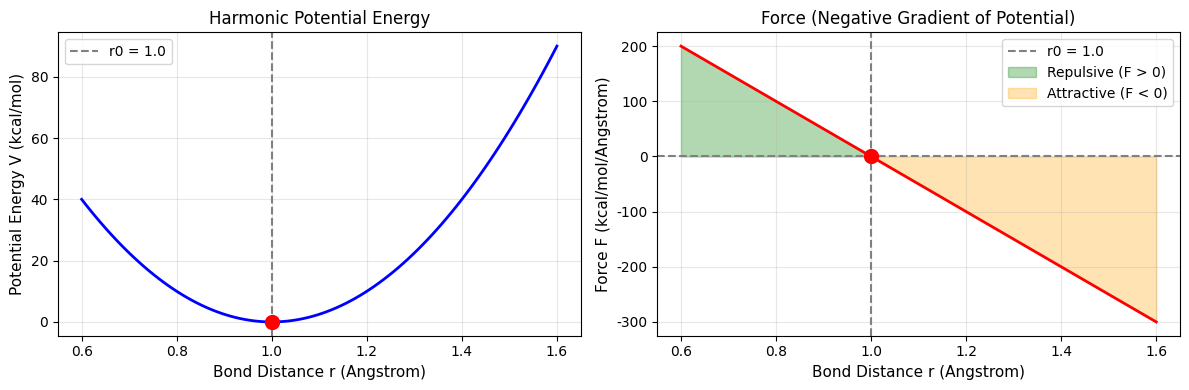

物理解释：
--------------------------------------------------
  当 r < r0（原子太近）：力为正（排斥），推动原子分开
  当 r > r0（原子太远）：力为负（吸引），拉动原子靠近
  当 r = r0（平衡位置）：力为零，系统稳定
--------------------------------------------------


In [6]:
#@title 3.1 弹簧模型：理解化学键力
#@markdown 化学键可以近似为弹簧：当原子偏离平衡位置时，会产生恢复力。
#@markdown
#@markdown 胡克定律：$F = -k(r - r_0)$
#@markdown
#@markdown 其中 $k$ 是弹簧常数，$r$ 是当前距离，$r_0$ 是平衡距离。

def spring_force_demo():
    """演示弹簧模型"""
    # 参数
    r0 = 1.0  # 平衡键长 (埃)
    k = 500   # 弹簧常数 (kcal/mol/埃^2)

    # 生成距离范围
    r = np.linspace(0.6, 1.6, 100)

    # 计算势能和力
    V = 0.5 * k * (r - r0) ** 2  # 势能
    F = -k * (r - r0)            # 力 (势能的负梯度)

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 势能曲线
    axes[0].plot(r, V, 'b-', linewidth=2)
    axes[0].axvline(x=r0, color='gray', linestyle='--', label=f'r0 = {r0}')
    axes[0].scatter([r0], [0], color='red', s=100, zorder=5)
    axes[0].set_xlabel('Bond Distance r (Angstrom)', fontsize=11)
    axes[0].set_ylabel('Potential Energy V (kcal/mol)', fontsize=11)
    axes[0].set_title('Harmonic Potential Energy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 力曲线
    axes[1].plot(r, F, 'r-', linewidth=2)
    axes[1].axhline(y=0, color='gray', linestyle='--')
    axes[1].axvline(x=r0, color='gray', linestyle='--', label=f'r0 = {r0}')
    axes[1].fill_between(r[r < r0], F[r < r0], 0, alpha=0.3, color='green', label='Repulsive (F > 0)')
    axes[1].fill_between(r[r > r0], F[r > r0], 0, alpha=0.3, color='orange', label='Attractive (F < 0)')
    axes[1].scatter([r0], [0], color='red', s=100, zorder=5)
    axes[1].set_xlabel('Bond Distance r (Angstrom)', fontsize=11)
    axes[1].set_ylabel('Force F (kcal/mol/Angstrom)', fontsize=11)
    axes[1].set_title('Force (Negative Gradient of Potential)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("物理解释：")
    print("-" * 50)
    print("  当 r < r0（原子太近）：力为正（排斥），推动原子分开")
    print("  当 r > r0（原子太远）：力为负（吸引），拉动原子靠近")
    print("  当 r = r0（平衡位置）：力为零，系统稳定")
    print("-" * 50)

spring_force_demo()

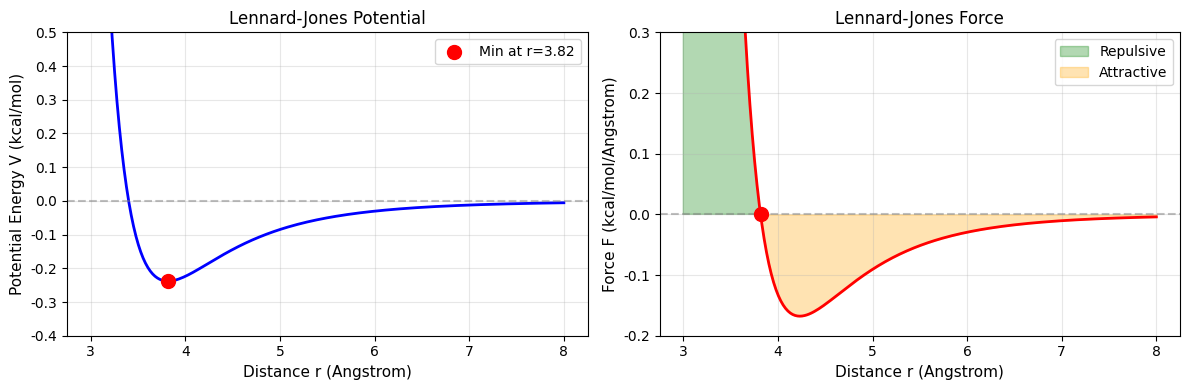

Lennard-Jones 势的两个部分：
--------------------------------------------------
  r^(-12) 项：短程排斥（泡利不相容原理）
  r^(-6)  项：长程吸引（范德华力/色散力）
  平衡距离: 3.816 埃
  势阱深度: 0.238 kcal/mol
--------------------------------------------------


In [7]:
#@title 3.2 Lennard-Jones 势：更真实的原子相互作用
#@markdown 真实的原子相互作用比弹簧模型更复杂。Lennard-Jones 势描述了非键合原子之间的相互作用：
#@markdown
#@markdown $$V(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]$$
#@markdown
#@markdown 其中 $\epsilon$ 是势阱深度，$\sigma$ 是特征距离。

def lj_potential_demo():
    """Lennard-Jones 势演示"""
    # LJ 参数
    epsilon = 0.238  # kcal/mol (典型值)
    sigma = 3.4      # 埃 (典型值)

    # 距离范围
    r = np.linspace(3.0, 8.0, 200)

    # LJ 势能
    V = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)

    # LJ 力 (解析导数)
    F = 24 * epsilon * (2*(sigma**12)/(r**13) - (sigma**6)/(r**7))

    # 平衡距离
    r_min = sigma * (2**(1/6))
    V_min = -epsilon

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 势能曲线
    axes[0].plot(r, V, 'b-', linewidth=2)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].scatter([r_min], [V_min], color='red', s=100, zorder=5, label=f'Min at r={r_min:.2f}')
    axes[0].set_xlabel('Distance r (Angstrom)', fontsize=11)
    axes[0].set_ylabel('Potential Energy V (kcal/mol)', fontsize=11)
    axes[0].set_title('Lennard-Jones Potential', fontsize=12)
    axes[0].set_ylim(-0.4, 0.5)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 力曲线
    axes[1].plot(r, F, 'r-', linewidth=2)
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].fill_between(r[F > 0], F[F > 0], 0, alpha=0.3, color='green', label='Repulsive')
    axes[1].fill_between(r[F < 0], F[F < 0], 0, alpha=0.3, color='orange', label='Attractive')
    axes[1].scatter([r_min], [0], color='red', s=100, zorder=5)
    axes[1].set_xlabel('Distance r (Angstrom)', fontsize=11)
    axes[1].set_ylabel('Force F (kcal/mol/Angstrom)', fontsize=11)
    axes[1].set_title('Lennard-Jones Force', fontsize=12)
    axes[1].set_ylim(-0.2, 0.3)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Lennard-Jones 势的两个部分：")
    print("-" * 50)
    print("  r^(-12) 项：短程排斥（泡利不相容原理）")
    print("  r^(-6)  项：长程吸引（范德华力/色散力）")
    print(f"  平衡距离: {r_min:.3f} 埃")
    print(f"  势阱深度: {epsilon:.3f} kcal/mol")
    print("-" * 50)

lj_potential_demo()

In [9]:
#@title 3.3 交互式探索：调整势函数参数
#@markdown 拖动滑块，观察参数变化如何影响势能曲线和力。
#@markdown
#@markdown ---
#@markdown ### 参数说明
#@markdown
#@markdown | 参数 | 物理意义 | 典型值 | 影响 |
#@markdown |------|----------|--------|------|
#@markdown | **ε (epsilon)** | 势阱深度 | 0.1-0.5 kcal/mol | 控制原子间吸引力强度 |
#@markdown | **σ (sigma)** | 特征距离 | 2.5-4.5 Å | 控制原子的有效大小 |
#@markdown
#@markdown ---
#@markdown ### 参数的物理来源
#@markdown
#@markdown - **ε (epsilon)**：来自原子的**极化率**，反映电子云的可变形性。极化率越大，原子间色散力越强，ε 越大。
#@markdown - **σ (sigma)**：来自原子的**范德华半径**，反映电子云的空间范围。原子越大，σ 越大。
#@markdown
#@markdown ---
#@markdown ### 不同原子的典型参数
#@markdown
#@markdown | 原子 | ε (kcal/mol) | σ (Å) |
#@markdown |------|--------------|-------|
#@markdown | H | 0.02 | 2.5 |
#@markdown | C | 0.07 | 3.4 |
#@markdown | N | 0.16 | 3.3 |
#@markdown | O | 0.21 | 3.0 |
#@markdown | Ar | 0.24 | 3.4 |
#@markdown
#@markdown ---
#@markdown ### 观察要点
#@markdown
#@markdown - 增大 **ε**：势阱变深，吸引力变强
#@markdown - 增大 **σ**：平衡距离变远，原子"更大"
#@markdown - **红点**：平衡位置（力 = 0）
#@markdown
#@markdown ---
#@markdown ### 图例说明
#@markdown
#@markdown - **Minimum**（最低点）：势能曲线的最低位置，对应最稳定的原子间距
#@markdown - **Equilibrium**（平衡点）：力为零的位置，原子间既不吸引也不排斥

from ipywidgets import interact

@interact(
    epsilon=widgets.FloatSlider(value=0.24, min=0.1, max=0.5, step=0.02, description='ε (epsilon):'),
    sigma=widgets.FloatSlider(value=3.4, min=2.5, max=4.5, step=0.1, description='σ (sigma):')
)
def update_lj_plot(epsilon=0.24, sigma=3.4):
    """绘制 LJ 势能和力曲线"""
    r = np.linspace(sigma * 0.9, sigma * 2.5, 200)
    V = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)
    F = 24 * epsilon * (2*(sigma**12)/(r**13) - (sigma**6)/(r**7))
    r_min = sigma * (2**(1/6))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 势能曲线
    axes[0].plot(r, V, 'b-', linewidth=2)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].axhline(y=-epsilon, color='green', linestyle=':', alpha=0.5, label=f'ε = {epsilon:.2f}')
    axes[0].scatter([r_min], [-epsilon], color='red', s=100, zorder=5, label=f'Minimum')
    axes[0].set_xlabel('Distance r (Å)', fontsize=11)
    axes[0].set_ylabel('Potential Energy V (kcal/mol)', fontsize=11)
    axes[0].set_title(f'Lennard-Jones Potential', fontsize=12)
    axes[0].set_ylim(-0.6, 0.6)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # 力曲线
    axes[1].plot(r, F, 'r-', linewidth=2)
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(x=r_min, color='green', linestyle=':', alpha=0.5, label=f'r_eq = {r_min:.2f} Å')
    axes[1].scatter([r_min], [0], color='red', s=100, zorder=5, label='Equilibrium')
    axes[1].set_xlabel('Distance r (Å)', fontsize=11)
    axes[1].set_ylabel('Force F (kcal/mol/Å)', fontsize=11)
    axes[1].set_title(f'Lennard-Jones Force', fontsize=12)
    axes[1].set_ylim(-0.3, 0.4)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 简化输出
    print(f"当前参数: ε = {epsilon:.2f} kcal/mol, σ = {sigma:.1f} Å")
    print(f"平衡距离: r_eq = {r_min:.2f} Å（力为零的位置）")

interactive(children=(FloatSlider(value=0.24, description='ε (epsilon):', max=0.5, min=0.1, step=0.02), FloatS…

# 第四部分：构建 AI 力场模型

现在让我们构建一个简单的神经网络，学习预测原子间作用力。

## AI 力场的核心思想

传统力场使用固定的数学公式（如 LJ 势），而 AI 力场使用神经网络学习从原子结构到力的映射：

**输入**：原子类型 + 原子坐标 -> **神经网络** -> **输出**：每个原子的力矢量 (Fx, Fy, Fz)

In [10]:
#@title 4.1 生成训练数据
#@markdown 我们使用简化的物理模型（谐振子 + LJ 势）生成「真实」的力数据。
#@markdown
#@markdown 在实际研究中，这些数据来自 DFT 量子化学计算。

def compute_forces_physics(coords, atoms, params):
    """
    使用简化物理模型计算原子力

    包含：
    1. 键合力（谐振子模型）
    2. 非键合力（LJ 势）
    """
    n_atoms = len(atoms)
    forces = np.zeros_like(coords)

    # 键合参数（简化）
    bond_params = {
        ('O', 'H'): {'r0': 0.96, 'k': 500},
        ('C', 'H'): {'r0': 1.09, 'k': 400},
        ('C', 'C'): {'r0': 1.54, 'k': 350},
        ('C', 'O'): {'r0': 1.16, 'k': 600},
        ('N', 'H'): {'r0': 1.01, 'k': 450},
    }

    # LJ 参数（简化）
    lj_params = {
        'H': {'epsilon': 0.05, 'sigma': 2.5},
        'C': {'epsilon': 0.10, 'sigma': 3.4},
        'N': {'epsilon': 0.08, 'sigma': 3.3},
        'O': {'epsilon': 0.06, 'sigma': 3.1},
    }

    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            # 计算距离向量
            r_vec = coords[j] - coords[i]
            r = np.linalg.norm(r_vec)
            r_hat = r_vec / (r + 1e-10)  # 单位向量

            # 检查是否是键合原子对
            bond_key = tuple(sorted([atoms[i], atoms[j]]))

            if bond_key in bond_params and r < 2.0:  # 键合力
                p = bond_params[bond_key]
                f_mag = -p['k'] * (r - p['r0'])  # 胡克定律
            else:  # 非键合力 (LJ)
                eps_i = lj_params.get(atoms[i], {'epsilon': 0.1})['epsilon']
                eps_j = lj_params.get(atoms[j], {'epsilon': 0.1})['epsilon']
                sig_i = lj_params.get(atoms[i], {'sigma': 3.0})['sigma']
                sig_j = lj_params.get(atoms[j], {'sigma': 3.0})['sigma']

                epsilon = np.sqrt(eps_i * eps_j)
                sigma = (sig_i + sig_j) / 2

                # LJ 力
                if r > 0.5:
                    f_mag = 24 * epsilon * (2*(sigma**12)/(r**13) - (sigma**6)/(r**7))
                else:
                    f_mag = 0

            # 分配力（牛顿第三定律）
            f_vec = f_mag * r_hat
            forces[i] -= f_vec
            forces[j] += f_vec

    return forces


def generate_training_data(mol_key, n_samples=5000, perturbation=0.05):
    """
    通过扰动平衡结构生成训练数据
    """
    mol_data = MOLECULES[mol_key]
    atoms = mol_data['atoms']
    base_coords = mol_data['coords']
    n_atoms = len(atoms)

    # 存储数据
    all_coords = []
    all_forces = []

    for _ in range(n_samples):
        # 随机扰动坐标
        noise = np.random.normal(0, perturbation, base_coords.shape)
        perturbed_coords = base_coords + noise

        # 计算力
        forces = compute_forces_physics(perturbed_coords, atoms, {})

        all_coords.append(perturbed_coords)
        all_forces.append(forces)

    return np.array(all_coords), np.array(all_forces), atoms


# 生成水分子的训练数据
print("正在生成训练数据...")
print()

train_coords, train_forces, train_atoms = generate_training_data('H2O', n_samples=1000)

print("训练数据生成完成：")
print("-" * 40)
print(f"  分子: H2O (水)")
print(f"  样本数: {len(train_coords)}")
print(f"  每个样本: {len(train_atoms)} 个原子 x 3 个坐标分量")
print(f"  输入形状: {train_coords.shape}")
print(f"  输出形状: {train_forces.shape}")
print("-" * 40)
print()
print("数据预览（第一个样本）：")
print("原子     坐标 (x, y, z)              力 (Fx, Fy, Fz)")
print("-" * 60)
for i, atom in enumerate(train_atoms):
    c = train_coords[0, i]
    f = train_forces[0, i]
    print(f"  {atom}   ({c[0]:6.3f}, {c[1]:6.3f}, {c[2]:6.3f})   ({f[0]:7.2f}, {f[1]:7.2f}, {f[2]:7.2f})")

正在生成训练数据...

训练数据生成完成：
----------------------------------------
  分子: H2O (水)
  样本数: 1000
  每个样本: 3 个原子 x 3 个坐标分量
  输入形状: (1000, 3, 3)
  输出形状: (1000, 3, 3)
----------------------------------------

数据预览（第一个样本）：
原子     坐标 (x, y, z)              力 (Fx, Fy, Fz)
------------------------------------------------------------
  O   ( 0.025, -0.007,  0.149)   (497490.99, -52758.58, 1052733.70)
  H   ( 0.832, -0.012, -0.481)   (353338.11, -2116.29, -275254.26)
  H   (-0.677,  0.038, -0.492)   (-850829.09, 54874.87, -777479.44)


In [11]:
#@title 4.1.1 检查并归一化数据
#@markdown ### 为什么要归一化？
#@markdown
#@markdown 神经网络训练时，数据的数值范围对训练效果有很大影响：
#@markdown
#@markdown | 问题 | 原因 | 后果 |
#@markdown |------|------|------|
#@markdown | **数值过大** | 力的值可能达到 10⁶ 量级 | 梯度爆炸，损失值巨大 |
#@markdown | **范围不一致** | 不同特征尺度差异大 | 某些特征主导学习 |
#@markdown | **优化困难** | 损失函数曲面陡峭 | 难以找到最优解 |
#@markdown
#@markdown ---
#@markdown ### 归一化的好处
#@markdown
#@markdown - **稳定训练**：梯度大小适中，不会爆炸或消失
#@markdown - **加速收敛**：损失函数更平滑，更快找到最优解
#@markdown - **公平学习**：所有特征贡献相当，不会被大数值主导
#@markdown
#@markdown ---
#@markdown ### 归一化方法
#@markdown
#@markdown 本实验使用**标准化（Z-score）**：
#@markdown
#@markdown $$x_{norm} = \frac{x - \mu}{\sigma}$$
#@markdown
#@markdown 其中 $\mu$ 是均值，$\sigma$ 是标准差。归一化后数据均值为0，标准差为1。

print("=" * 50)
print("原始数据统计：")
print("=" * 50)
print(f"坐标范围: [{train_coords.min():.4f}, {train_coords.max():.4f}]")
print(f"力的范围: [{train_forces.min():.4f}, {train_forces.max():.4f}]")
print(f"力的均值: {train_forces.mean():.4f}")
print(f"力的标准差: {train_forces.std():.4f}")
print()

# 归一化坐标（减去质心）
coords_mean = train_coords.mean(axis=(0, 1), keepdims=True)
train_coords_norm = train_coords - coords_mean

# 归一化力（标准化）
force_mean = train_forces.mean()
force_std = train_forces.std()
train_forces_norm = (train_forces - force_mean) / (force_std + 1e-8)

print("=" * 50)
print("归一化后统计：")
print("=" * 50)
print(f"坐标范围: [{train_coords_norm.min():.4f}, {train_coords_norm.max():.4f}]")
print(f"力的范围: [{train_forces_norm.min():.4f}, {train_forces_norm.max():.4f}]")
print(f"力的均值: {train_forces_norm.mean():.6f}")
print(f"力的标准差: {train_forces_norm.std():.6f}")
print()

# 保存归一化参数（预测时需要反归一化）
norm_params = {
    'coords_mean': coords_mean,
    'force_mean': force_mean,
    'force_std': force_std
}

# 替换原始数据
train_coords = train_coords_norm
train_forces = train_forces_norm

print("=" * 50)
print("数据已归一化！")
print("=" * 50)


原始数据统计：
坐标范围: [-0.9404, 0.8972]
力的范围: [-43942077.3808, 41821165.8335]
力的均值: 0.0000
力的标准差: 2112132.2952

归一化后统计：
坐标范围: [-0.9398, 0.8978]
力的范围: [-20.8046, 19.8004]
力的均值: -0.000000
力的标准差: 1.000000

数据已归一化！


In [12]:
#@title 4.2 定义神经网络模型
#@markdown 我们使用一个简单的多层感知器（MLP）作为 AI 力场模型。
#@markdown
#@markdown 模型结构：
#@markdown - 输入层：原子间距离特征
#@markdown - 隐藏层：全连接 + ReLU 激活
#@markdown - 输出层：每个原子的力分量

class SimpleForceField(nn.Module):
    """
    简单的 AI 力场模型

    基于原子间距离预测原子力
    """

    def __init__(self, n_atoms, hidden_dim=64, n_layers=3):
        super().__init__()

        self.n_atoms = n_atoms

        # 计算距离特征的数量：n_atoms * (n_atoms - 1) / 2 个距离
        # 加上原子坐标本身
        n_distances = n_atoms * (n_atoms - 1) // 2
        input_dim = n_distances + n_atoms * 3  # 距离 + 坐标
        output_dim = n_atoms * 3  # 每个原子 3 个力分量

        # 构建网络层
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.network = nn.Sequential(*layers)

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def compute_distances(self, coords):
        """
        计算所有原子对之间的距离

        coords: (batch_size, n_atoms, 3)
        returns: (batch_size, n_distances)
        """
        batch_size = coords.shape[0]
        distances = []

        for i in range(self.n_atoms):
            for j in range(i + 1, self.n_atoms):
                r_vec = coords[:, j] - coords[:, i]
                r = torch.norm(r_vec, dim=1, keepdim=True)
                distances.append(r)

        return torch.cat(distances, dim=1)

    def forward(self, coords):
        """
        前向传播

        coords: (batch_size, n_atoms, 3)
        returns: (batch_size, n_atoms, 3) - 每个原子的力
        """
        batch_size = coords.shape[0]

        # 计算距离特征
        distances = self.compute_distances(coords)

        # 展平坐标
        flat_coords = coords.view(batch_size, -1)

        # 组合特征
        features = torch.cat([distances, flat_coords], dim=1)

        # 通过网络
        output = self.network(features)

        # 重塑为 (batch_size, n_atoms, 3)
        forces = output.view(batch_size, self.n_atoms, 3)

        return forces


# 创建模型
n_atoms = len(train_atoms)
model = SimpleForceField(n_atoms=n_atoms, hidden_dim=64, n_layers=3)
model = model.to(DEVICE)

# 统计参数数量
n_params = sum(p.numel() for p in model.parameters())

print("AI 力场模型构建完成：")
print("=" * 50)
print(f"  原子数: {n_atoms}")
print(f"  隐藏层维度: 64")
print(f"  网络层数: 3")
print(f"  总参数量: {n_params:,}")
print(f"  设备: {DEVICE}")
print("=" * 50)
print()
print("模型结构：")
print(model)

AI 力场模型构建完成：
  原子数: 3
  隐藏层维度: 64
  网络层数: 3
  总参数量: 9,737
  设备: cuda

模型结构：
SimpleForceField(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=9, bias=True)
  )
)


# 第五部分：训练与预测

现在让我们训练这个 AI 力场模型！

In [13]:
#@title 5.1 交互式训练控制面板
#@markdown 点击运行，调整超参数并观察训练过程。
#@markdown
#@markdown | 参数 | 说明 | 建议值 |
#@markdown |------|------|--------|
#@markdown | 学习率 | 控制每次更新的步长 | 0.001-0.01 |
#@markdown | 训练轮数 | 遍历数据集的次数 | 100-500 |
#@markdown | 批量大小 | 每次更新使用的样本数 | 32-128 |

# 创建交互式控件
lr_slider = widgets.FloatLogSlider(
    value=0.005, base=10, min=-4, max=-1, step=0.2,
    description='Learning Rate:', style={'description_width': 'initial'}
)
epochs_slider = widgets.IntSlider(
    value=200, min=50, max=500, step=50,
    description='Epochs:', style={'description_width': 'initial'}
)
batch_slider = widgets.IntSlider(
    value=64, min=16, max=128, step=16,
    description='Batch Size:', style={'description_width': 'initial'}
)
train_button = widgets.Button(
    description='Start Training',
    button_style='success',
    icon='play'
)

output_area = widgets.Output()

# 存储训练历史
training_history = {'train_loss': [], 'val_loss': []}

# ===== 带 Dropout 的模型 =====
class SimpleForceFieldWithDropout(nn.Module):
    """带正则化的神经网络力场模型"""

    def __init__(self, n_atoms, hidden_dim=64, n_layers=3, dropout=0.2):
        super().__init__()

        self.n_atoms = n_atoms
        n_distances = n_atoms * (n_atoms - 1) // 2
        input_dim = n_distances + n_atoms * 3
        output_dim = n_atoms * 3

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.network = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, coords):
        batch_size = coords.shape[0]
        coords_flat = coords.view(batch_size, -1)

        distances = []
        for i in range(self.n_atoms):
            for j in range(i + 1, self.n_atoms):
                diff = coords[:, i] - coords[:, j]
                dist = torch.norm(diff, dim=1, keepdim=True)
                distances.append(dist)

        distances = torch.cat(distances, dim=1)
        features = torch.cat([distances, coords_flat], dim=1)

        forces = self.network(features)
        return forces.view(batch_size, self.n_atoms, 3)

def train_model(button):
    global model, training_history, X_train, y_train, X_val, y_val

    with output_area:
        clear_output(wait=True)

        # ===== 每次训练前重新准备数据 =====
        print("准备数据...")
        X_data = torch.tensor(train_coords, dtype=torch.float32).to(DEVICE)
        y_data = torch.tensor(train_forces, dtype=torch.float32).to(DEVICE)

        # 划分训练集和验证集
        n_val = int(len(X_data) * 0.2)
        X_val, y_val = X_data[-n_val:], y_data[-n_val:]
        X_train, y_train = X_data[:-n_val], y_data[:-n_val]

        print(f"训练集大小: {len(X_train)}")
        print(f"验证集大小: {len(X_val)}")
        print(f"数据范围: 坐标[{X_train.min():.2f}, {X_train.max():.2f}], 力[{y_train.min():.2f}, {y_train.max():.2f}]")
        print()

        # 使用带 Dropout 的模型
        model = SimpleForceFieldWithDropout(n_atoms=n_atoms, hidden_dim=64, n_layers=3, dropout=0.2)
        model = model.to(DEVICE)

        # 获取参数
        lr = lr_slider.value
        epochs = epochs_slider.value
        batch_size = batch_slider.value

        print("训练配置：")
        print(f"  学习率: {lr:.6f}")
        print(f"  训练轮数: {epochs}")
        print(f"  批量大小: {batch_size}")
        print(f"  Dropout: 0.2")
        print()
        print("开始训练...")
        print("=" * 50)

        # 优化器和损失函数
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=20
        )
        criterion = nn.MSELoss()

        # 训练历史
        training_history = {'train_loss': [], 'val_loss': []}

        # 训练循环
        n_batches = len(X_train) // batch_size

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0

            # 打乱数据
            perm = torch.randperm(len(X_train))
            X_shuffled = X_train[perm]
            y_shuffled = y_train[perm]

            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size

                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                optimizer.zero_grad()
                pred = model(X_batch)
                loss = criterion(pred, y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # 验证
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val).item()

            train_loss = epoch_loss / n_batches
            training_history['train_loss'].append(train_loss)
            training_history['val_loss'].append(val_loss)

            scheduler.step(val_loss)

            # 打印进度
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:4d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        print("=" * 50)
        print("训练完成！")
        print()

        # 绘制学习曲线
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(training_history['train_loss'], label='Train Loss', alpha=0.8)
        ax.plot(training_history['val_loss'], label='Val Loss', alpha=0.8)
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('MSE Loss', fontsize=11)
        ax.set_title('Training Progress', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        plt.tight_layout()
        plt.show()

        print(f"最终训练损失: {training_history['train_loss'][-1]:.6f}")
        print(f"最终验证损失: {training_history['val_loss'][-1]:.6f}")

train_button.on_click(train_model)

# 显示控件
controls = widgets.VBox([
    widgets.HTML("<h4>超参数调整</h4>"),
    lr_slider,
    epochs_slider,
    batch_slider,
    train_button
])

display(controls)
display(output_area)

Output()

In [29]:
#@title 5.2 可视化预测结果：力矢量场
#@markdown 查看 AI 预测的原子力与真实力的对比。
#@markdown
#@markdown ---
#@markdown ### 三个子图说明
#@markdown
#@markdown | 子图 | 内容 | 箭头颜色 |
#@markdown |------|------|----------|
#@markdown | **左图** | DFT计算的真实力 | 红色 |
#@markdown | **中图** | AI模型预测的力 | 蓝色 |
#@markdown | **右图** | 真实力与预测力叠加对比 | 红+蓝 |
#@markdown
#@markdown ---
#@markdown ### 如何解读
#@markdown
#@markdown - **箭头方向**：力的作用方向
#@markdown - **箭头长度**：力的大小
#@markdown - **对比图中**：红蓝箭头越接近，说明AI预测越准确
#@markdown
#@markdown ---
#@markdown ### Sample 滑块
#@markdown
#@markdown 每个样本是水分子在不同扰动下的构型，拖动滑块查看不同构型的预测效果。

from ipywidgets import interact

# H原子用浅蓝色，更容易看见
ATOM_COLORS_VIS = {
    'H': '#00BFFF',
    'C': '#808080',
    'N': '#0000FF',
    'O': '#FF0000',
    'S': '#FFFF00',
}

def visualize_force_vectors(sample_idx):
    """可视化单个样本的力矢量"""

    model.eval()

    # 获取数据
    coords = X_val[sample_idx:sample_idx+1]
    true_forces = y_val[sample_idx].cpu().numpy()

    with torch.no_grad():
        pred_forces = model(coords)[0].cpu().numpy()

    coords = coords[0].cpu().numpy()

    # 动态缩放因子
    max_force = max(np.abs(true_forces).max(), np.abs(pred_forces).max())
    scale = 0.3 / (max_force + 1e-6)

    # 创建 3D 图
    fig = plt.figure(figsize=(15, 5))

    # 子图 1：真实力
    ax1 = fig.add_subplot(131, projection='3d')
    for i, atom in enumerate(train_atoms):
        color = ATOM_COLORS_VIS.get(atom, '#888888')
        ax1.scatter(*coords[i], c=color, s=200, edgecolors='black', linewidth=1)
        ax1.quiver(*coords[i], *(true_forces[i]*scale), color='red', arrow_length_ratio=0.3, linewidth=2)
        ax1.text(coords[i,0], coords[i,1], coords[i,2]+0.15, atom, fontsize=9, ha='center')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('True Forces (DFT)', fontsize=12)

    # 子图 2：预测力
    ax2 = fig.add_subplot(132, projection='3d')
    for i, atom in enumerate(train_atoms):
        color = ATOM_COLORS_VIS.get(atom, '#888888')
        ax2.scatter(*coords[i], c=color, s=200, edgecolors='black', linewidth=1)
        ax2.quiver(*coords[i], *(pred_forces[i]*scale), color='blue', arrow_length_ratio=0.3, linewidth=2)
        ax2.text(coords[i,0], coords[i,1], coords[i,2]+0.15, atom, fontsize=9, ha='center')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title('AI Predicted Forces', fontsize=12)

    # 子图 3：对比
    ax3 = fig.add_subplot(133, projection='3d')
    for i, atom in enumerate(train_atoms):
        color = ATOM_COLORS_VIS.get(atom, '#888888')
        ax3.scatter(*coords[i], c=color, s=200, edgecolors='black', linewidth=1)
        ax3.quiver(*coords[i], *(true_forces[i]*scale), color='red', arrow_length_ratio=0.3, linewidth=2, alpha=0.7, label='True' if i==0 else '')
        ax3.quiver(*coords[i], *(pred_forces[i]*scale), color='blue', arrow_length_ratio=0.3, linewidth=2, alpha=0.7, label='Pred' if i==0 else '')
        ax3.text(coords[i,0], coords[i,1], coords[i,2]+0.15, atom, fontsize=9, ha='center')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.set_title('Comparison', fontsize=12)
    ax3.legend(loc='upper left')

    plt.suptitle(f'Force Field Visualization (Sample {sample_idx})', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 打印数值对比
    print("力矢量数值对比：")
    print("=" * 70)
    print(f"{'Atom':^6} {'True Fx':>10} {'Pred Fx':>10} {'True Fy':>10} {'Pred Fy':>10} {'True Fz':>10} {'Pred Fz':>10}")
    print("-" * 70)
    for i, atom in enumerate(train_atoms):
        print(f"{atom:^6} {true_forces[i,0]:>10.3f} {pred_forces[i,0]:>10.3f} {true_forces[i,1]:>10.3f} {pred_forces[i,1]:>10.3f} {true_forces[i,2]:>10.3f} {pred_forces[i,2]:>10.3f}")
    print("=" * 70)

    # 计算并显示误差
    mae = np.mean(np.abs(true_forces - pred_forces))
    print(f"\n该样本的平均绝对误差 (MAE): {mae:.4f}")

# 使用 interact（更稳定）
print("Select a validation sample to visualize:")
print()

interact(
    visualize_force_vectors,
    sample_idx=widgets.IntSlider(
        value=0,
        min=0,
        max=len(X_val)-1,
        step=1,
        description='Sample:',
        continuous_update=False
    )
);

Select a validation sample to visualize:



interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample:', max=199), Output()), …

# 第六部分：结果分析与验证

让我们定量分析 AI 力场的预测性能。

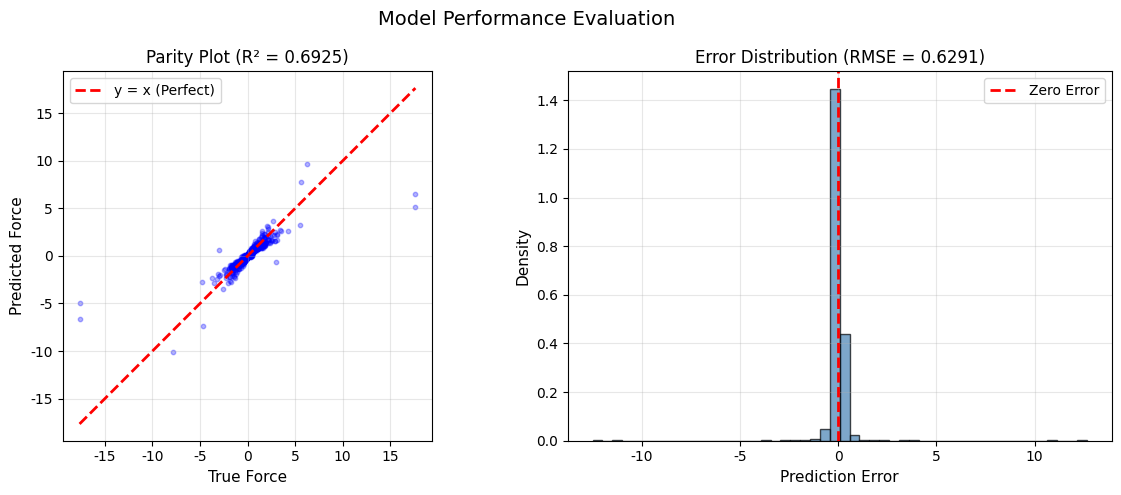

模型性能评估：
  R² 分数:     0.692524
  RMSE:        0.629114
  MAE:         0.166673
  MSE:         0.395784

性能评级：
  ★★☆☆☆ 较差。模型需要更多优化。


In [30]:
#@title 6.1 预测 vs 真实值散点图
#@markdown 评估 AI 模型的整体预测性能。
#@markdown
#@markdown ---
#@markdown ### 两个图表说明
#@markdown
#@markdown | 图表 | 内容 | 理想情况 |
#@markdown |------|------|----------|
#@markdown | **左图 (散点图)** | 预测值 vs 真实值 | 所有点落在红色对角线上 |
#@markdown | **右图 (直方图)** | 预测误差的分布 | 以0为中心的窄峰 |
#@markdown
#@markdown ---
#@markdown ### 评估指标说明
#@markdown
#@markdown | 指标 | 含义 | 理想值 |
#@markdown |------|------|--------|
#@markdown | **R²** | 决定系数，越接近1越好 | > 0.99 |
#@markdown | **RMSE** | 均方根误差，越小越好 | < 0.5 |
#@markdown | **MAE** | 平均绝对误差，越小越好 | < 0.3 |
#@markdown
#@markdown ---
#@markdown ### 如何解读
#@markdown
#@markdown - **散点图**：点越集中在对角线附近，预测越准确
#@markdown - **误差直方图**：分布越窄越好，偏离0表示系统性偏差

def plot_parity():
    """绘制预测值 vs 真实值散点图"""

    model.eval()

    with torch.no_grad():
        pred_all = model(X_val).cpu().numpy().flatten()
    true_all = y_val.cpu().numpy().flatten()

    # 计算统计量
    mse = np.mean((pred_all - true_all) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(pred_all - true_all))
    r2 = 1 - np.sum((true_all - pred_all)**2) / np.sum((true_all - np.mean(true_all))**2)

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 散点图
    axes[0].scatter(true_all, pred_all, alpha=0.3, s=10, c='blue')

    # 对角线
    lims = [min(true_all.min(), pred_all.min()), max(true_all.max(), pred_all.max())]
    axes[0].plot(lims, lims, 'r--', linewidth=2, label='y = x (Perfect)')

    axes[0].set_xlabel('True Force', fontsize=11)
    axes[0].set_ylabel('Predicted Force', fontsize=11)
    axes[0].set_title(f'Parity Plot (R² = {r2:.4f})', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_aspect('equal')

    # 误差分布直方图
    errors = pred_all - true_all
    axes[1].hist(errors, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[1].set_xlabel('Prediction Error', fontsize=11)
    axes[1].set_ylabel('Density', fontsize=11)
    axes[1].set_title(f'Error Distribution (RMSE = {rmse:.4f})', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Model Performance Evaluation', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 打印统计量
    print("模型性能评估：")
    print("=" * 40)
    print(f"  R² 分数:     {r2:.6f}")
    print(f"  RMSE:        {rmse:.6f}")
    print(f"  MAE:         {mae:.6f}")
    print(f"  MSE:         {mse:.6f}")
    print("=" * 40)
    print()

    # 模型评价
    print("性能评级：")
    if r2 > 0.95:
        print("  ★★★★★ 优秀！AI 成功学习了原子力的规律。")
    elif r2 > 0.85:
        print("  ★★★★☆ 良好。可以尝试增加训练轮数或调整网络结构。")
    elif r2 > 0.7:
        print("  ★★★☆☆ 一般。建议增加训练数据或调整超参数。")
    elif r2 > 0.50:
        print("  ★★☆☆☆ 较差。模型需要更多优化。")
    else:
        print("  ★☆☆☆☆ 需要改进。请检查数据和模型设置。")

plot_parity()

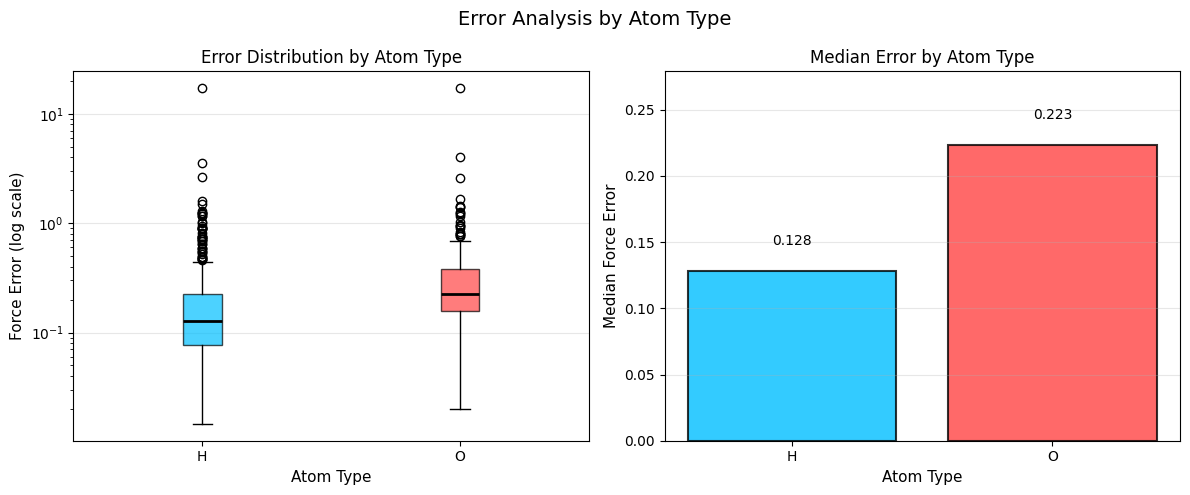

按原子类型的误差统计：
 Atom        Median         Mean          Std          Max
-----------------------------------------------------------------
  H          0.1278       0.2682       0.9064      17.1976
  O          0.2232       0.4445       1.2561      17.1304

总体中位数误差: 0.1630

模型评价：
  ★★★★★ 优秀！


In [31]:
#@title 6.2 按原子类型分析误差
#@markdown 分析不同原子类型的预测误差，了解模型的优势和不足。
#@markdown
#@markdown ---
#@markdown ### 两个图表说明
#@markdown
#@markdown | 图表 | 内容 | 用途 |
#@markdown |------|------|------|
#@markdown | **左图 (箱线图)** | 各原子类型误差的分布 | 查看误差范围和离群点 |
#@markdown | **右图 (柱状图)** | 各原子类型的平均误差 | 对比不同原子的预测难度 |
#@markdown
#@markdown ---
#@markdown ### 如何解读
#@markdown
#@markdown - **箱线图**：箱体越窄，预测越稳定；离群点越少越好
#@markdown - **柱状图**：柱子越矮，预测误差越小
#@markdown - **误差棒**：表示标准差，越短说明预测越一致
#@markdown
#@markdown ---
#@markdown ### 物理意义
#@markdown
#@markdown 通常**H原子**的力更难预测（质量小、运动幅度大），而**重原子**（如O、C）相对容易。


# H原子用浅蓝色
ATOM_COLORS_VIS = {
    'H': '#00BFFF',
    'C': '#808080',
    'N': '#3232FF',
    'O': '#FF4444',
    'S': '#FFFF00',
}

def analyze_error_by_atom():
    """按原子类型分析预测误差"""

    model.eval()

    with torch.no_grad():
        pred_all = model(X_val).cpu().numpy()
    true_all = y_val.cpu().numpy()

    # 按原子类型计算误差
    atom_errors = {atom: [] for atom in set(train_atoms)}

    for sample_idx in range(len(X_val)):
        for atom_idx, atom in enumerate(train_atoms):
            error = np.linalg.norm(pred_all[sample_idx, atom_idx] - true_all[sample_idx, atom_idx])
            atom_errors[atom].append(error)

    # 绘制图表
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    atoms = list(atom_errors.keys())
    data = [atom_errors[atom] for atom in atoms]
    colors = [ATOM_COLORS_VIS.get(atom, '#888888') for atom in atoms]

    # 左图：箱线图（对数尺度）
    bp = axes[0].boxplot(data, labels=atoms, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)
    axes[0].set_xlabel('Atom Type', fontsize=11)
    axes[0].set_ylabel('Force Error (log scale)', fontsize=11)
    axes[0].set_title('Error Distribution by Atom Type', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3, axis='y')

    # 右图：使用中位数
    median_errors = [np.median(atom_errors[atom]) for atom in atoms]

    bars = axes[1].bar(atoms, median_errors, color=colors,
                       edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1].set_xlabel('Atom Type', fontsize=11)
    axes[1].set_ylabel('Median Force Error', fontsize=11)
    axes[1].set_title('Median Error by Atom Type', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')

    # 动态偏移量
    max_height = max(median_errors) if median_errors else 1
    offset = max_height * 0.08  # 5% 偏移

    for bar, med_err in zip(bars, median_errors):
        axes[1].text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + offset,
                     f'{med_err:.3f}',
                     ha='center', va='bottom', fontsize=10)

        axes[1].set_ylim(0, max_height * 1.25)

    plt.suptitle('Error Analysis by Atom Type', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print("按原子类型的误差统计：")
    print("=" * 65)
    print(f"{'Atom':^6} {'Median':>12} {'Mean':>12} {'Std':>12} {'Max':>12}")
    print("-" * 65)
    for atom in atoms:
        errors = np.array(atom_errors[atom])
        print(f"{atom:^6} {np.median(errors):>12.4f} {np.mean(errors):>12.4f} {np.std(errors):>12.4f} {np.max(errors):>12.4f}")
    print("=" * 65)

    # 总体评估
    all_errors = [e for errors in atom_errors.values() for e in errors]
    overall_median = np.median(all_errors)

    print(f"\n总体中位数误差: {overall_median:.4f}")

    # 模型评价
    print("\n模型评价：")
    if overall_median < 0.5:
        print("  ★★★★★ 优秀！")
    elif overall_median < 1.0:
        print("  ★★★★☆ 良好")
    elif overall_median < 2.0:
        print("  ★★★☆☆ 一般")
    else:
        print("  ★★☆☆☆ 需改进")

analyze_error_by_atom()

# 第七部分：扩展实验

尝试用不同的分子进行实验！

实验配置：
  分子: NH3 (氨)
  样本数: 1200
  训练轮数: 150
  学习率: 0.005

正在生成训练数据...
数据生成完成: (1200, 4, 3)
原始数据 - 坐标范围: [-0.98, 1.16]
原始数据 - 力的范围: [-22691306.83, 23576775.53]

正在归一化数据...
归一化后 - 坐标范围: [-0.98, 1.16]
归一化后 - 力的范围: [-16.17, 16.80]

开始训练...
--------------------------------------------------
Epoch   40/150 | Train Loss: 0.179552 | Val Loss: 0.263022
Epoch   80/150 | Train Loss: 0.127947 | Val Loss: 0.201685
Epoch  120/150 | Train Loss: 0.101116 | Val Loss: 0.140810
--------------------------------------------------
训练完成！



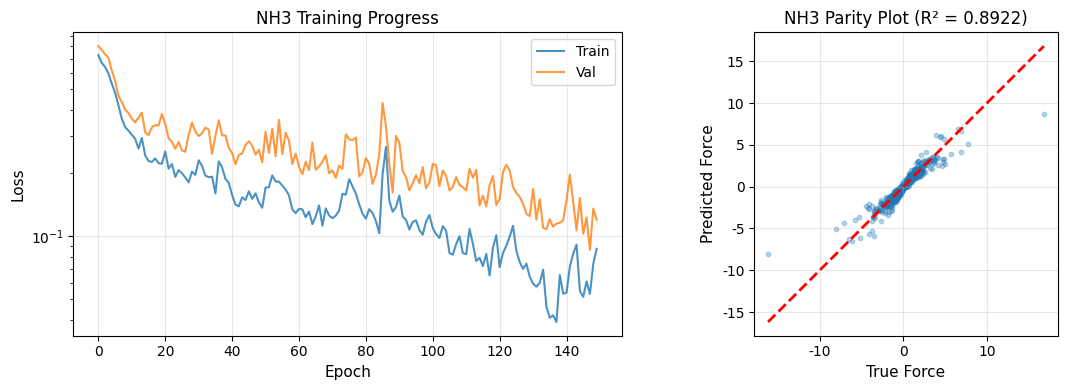

最终性能 (R²): 0.892205
评价: ★★★★☆ 良好


In [32]:
#@title 7.1 自定义实验：选择不同分子
#@markdown 选择一个分子，训练新的 AI 力场模型。
#@markdown
#@markdown ---
#@markdown ### 选择分子：
molecule_choice = "NH3" #@param ["H2O", "CH4", "CO2", "NH3", "C2H6"]

#@markdown ---
#@markdown ### 训练参数：
n_samples_custom = 1200 #@param {type:"slider", min:200, max:2000, step:200}
n_epochs_custom = 150 #@param {type:"slider", min:50, max:500, step:50}
learning_rate_custom = 0.005 #@param {type:"number"}
#@markdown ---

print("实验配置：")
print("=" * 50)
print(f"  分子: {molecule_choice} ({MOLECULES[molecule_choice]['name']})")
print(f"  样本数: {n_samples_custom}")
print(f"  训练轮数: {n_epochs_custom}")
print(f"  学习率: {learning_rate_custom}")
print("=" * 50)
print()

# 生成数据
print("正在生成训练数据...")
custom_coords, custom_forces, custom_atoms = generate_training_data(
    molecule_choice, n_samples=n_samples_custom
)
print(f"数据生成完成: {custom_coords.shape}")
print(f"原始数据 - 坐标范围: [{custom_coords.min():.2f}, {custom_coords.max():.2f}]")
print(f"原始数据 - 力的范围: [{custom_forces.min():.2f}, {custom_forces.max():.2f}]")
print()

# ===== 关键：归一化（修复变量名）=====
print("正在归一化数据...")
coords_mean = custom_coords.mean(axis=(0, 1), keepdims=True)
custom_coords = custom_coords - coords_mean

force_mean = custom_forces.mean()
force_std = custom_forces.std()
custom_forces = (custom_forces - force_mean) / (force_std + 1e-8)

print(f"归一化后 - 坐标范围: [{custom_coords.min():.2f}, {custom_coords.max():.2f}]")
print(f"归一化后 - 力的范围: [{custom_forces.min():.2f}, {custom_forces.max():.2f}]")
print()

# 准备数据
X_custom = torch.tensor(custom_coords, dtype=torch.float32).to(DEVICE)
y_custom = torch.tensor(custom_forces, dtype=torch.float32).to(DEVICE)

n_val_custom = int(len(X_custom) * 0.2)
X_val_custom = X_custom[-n_val_custom:]
y_val_custom = y_custom[-n_val_custom:]
X_train_custom = X_custom[:-n_val_custom]
y_train_custom = y_custom[:-n_val_custom]

# 创建模型
n_atoms_custom = len(custom_atoms)
model_custom = SimpleForceField(n_atoms=n_atoms_custom, hidden_dim=64, n_layers=3)
model_custom = model_custom.to(DEVICE)

# 训练
print("开始训练...")
print("-" * 50)

optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=learning_rate_custom)
criterion_custom = nn.MSELoss()
batch_size_custom = 64

history_custom = {'train_loss': [], 'val_loss': []}

for epoch in range(n_epochs_custom):
    model_custom.train()

    perm = torch.randperm(len(X_train_custom))
    epoch_loss = 0
    n_batches = len(X_train_custom) // batch_size_custom

    for i in range(n_batches):
        start = i * batch_size_custom
        end = start + batch_size_custom
        idx = perm[start:end]

        optimizer_custom.zero_grad()
        pred = model_custom(X_train_custom[idx])
        loss = criterion_custom(pred, y_train_custom[idx])
        loss.backward()
        optimizer_custom.step()
        epoch_loss += loss.item()

    model_custom.eval()
    with torch.no_grad():
        val_pred = model_custom(X_val_custom)
        val_loss = criterion_custom(val_pred, y_val_custom).item()

    train_loss = epoch_loss / n_batches
    history_custom['train_loss'].append(train_loss)
    history_custom['val_loss'].append(val_loss)

    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1:4d}/{n_epochs_custom} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("-" * 50)
print("训练完成！")
print()

# 绘制结果
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 学习曲线
axes[0].plot(history_custom['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history_custom['val_loss'], label='Val', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title(f'{molecule_choice} Training Progress', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Parity plot
model_custom.eval()
with torch.no_grad():
    pred_custom = model_custom(X_val_custom).cpu().numpy().flatten()
true_custom = y_val_custom.cpu().numpy().flatten()

r2_custom = 1 - np.sum((true_custom - pred_custom)**2) / np.sum((true_custom - np.mean(true_custom))**2)

axes[1].scatter(true_custom, pred_custom, alpha=0.3, s=10)
lims = [min(true_custom.min(), pred_custom.min()), max(true_custom.max(), pred_custom.max())]
axes[1].plot(lims, lims, 'r--', linewidth=2)
axes[1].set_xlabel('True Force', fontsize=11)
axes[1].set_ylabel('Predicted Force', fontsize=11)
axes[1].set_title(f'{molecule_choice} Parity Plot (R² = {r2_custom:.4f})', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"最终性能 (R²): {r2_custom:.6f}")

if r2_custom > 0.95:
    print("评价: ★★★★★ 优秀！")
elif r2_custom > 0.85:
    print("评价: ★★★★☆ 良好")
elif r2_custom > 0.7:
    print("评价: ★★★☆☆ 一般")
else:
    print("评价: ★★☆☆☆ 需要更多训练或数据")

# 实验总结

## 今天你学到了什么？

1. **原子间作用力**来自量子力学效应，包括化学键力、范德华力等

2. **传统力场**使用预定义的数学公式（如谐振子、LJ势）

3. **AI力场**使用神经网络学习从分子结构到原子力的映射

4. **关键技术点**：
   - 使用原子间距离作为特征（旋转不变性）
   - 神经网络拟合势能面
   - 力是势能对坐标的负梯度

## 思考题

1. 为什么使用原子间距离而不是绝对坐标作为输入？

2. AI力场模型是否真正「理解」了物理？还是只是在拟合数据？

3. 如何处理更大的分子系统（成千上万个原子）？

4. AI力场在哪些应用场景中最有价值？

## 延伸阅读

- [SchNet: A continuous-filter convolutional neural network](https://arxiv.org/abs/1706.08566)
- [E(3)-equivariant graph neural networks (E3NN)](https://e3nn.org/)
- [MACE: Higher Order Equivariant Message Passing](https://arxiv.org/abs/2206.07697)
- [ANI: Deep learning potentials](https://aiqm.github.io/torchani/)

---

**恭喜完成实验！** 你已经体验了 AI 如何「看见」分子世界中的力！